In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

import boto3
import os

#### Settings

In [2]:
base_dir = '/home/sagemaker-user/sagemaker/01_Iris_simple_e2e'
bucket_name = 'sagemaker-bucket-ds'
project_path_s3 = 'iris_v2'

#### Read data

In [6]:
iris = datasets.load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df["class"] = pd.Series(iris.target)
df = df[[list(df.columns)[-1]] + list(df.columns)[:-1]] # Reorder target as the first column
df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.head()

,class,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm
0,0,5.1,3.5,1.4,0.2
1,0,4.9,3.0,1.4,0.2
2,0,4.7,3.2,1.3,0.2
3,0,4.6,3.1,1.5,0.2
4,0,5.0,3.6,1.4,0.2


In [11]:
# Get the cleaned column names as a comma-separated list

column_names_list


'class,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm'

#### Train - Test split

In [7]:
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42, stratify=df["class"])

#### Paths to files

In [12]:
data_local_path = os.path.join(base_dir, 'data') # Folder with data
train_local_path = os.path.join(data_local_path, 'iris_train.csv') # Path to CSV file with train
test_local_path = os.path.join(data_local_path, 'iris_test.csv') # Path to CSV file with test
infer_local_path = os.path.join(data_local_path, 'iris_infer.csv') # Path to CSV file with inference input
column_names_path = os.path.join(data_local_path, 'iris_column_names.csv') # Path to file with list of column names

#### Save data frames
The data frames should be in following format:
- Separated by ','
- Without headers
- Without index column
- Only target and columns used in the model
- Target column must be first

In [13]:
os.makedirs(data_local_path, exist_ok=True) # Create data folder
train_df.to_csv(train_local_path, index=False, header=None)
test_df.to_csv(test_local_path, index=False, header=None)

infer_df = test_df.drop(columns=["class"]) # In the inference input file we don't want to have target
infer_df.to_csv(infer_local_path, index=False, header=None)

column_names_list = ','.join(df.columns)
with open(column_names_path, 'w') as file:
    file.write(column_names_list)

#### Let's verify how the files look like

In [17]:
!head {train_local_path}

2,6.3,3.4,5.6,2.4
0,5.1,3.5,1.4,0.3
2,5.8,2.7,5.1,1.9
1,5.2,2.7,3.9,1.4
0,4.6,3.4,1.4,0.3
0,5.2,4.1,1.5,0.1
0,5.7,4.4,1.5,0.4
2,6.4,3.1,5.5,1.8
0,4.8,3.1,1.6,0.2
0,4.9,3.1,1.5,0.2


In [18]:
!head {test_local_path}

2,6.3,2.8,5.1,1.5
1,6.3,3.3,4.7,1.6
0,5.0,3.4,1.5,0.2
1,5.8,2.7,4.1,1.0
2,7.3,2.9,6.3,1.8
1,4.9,2.4,3.3,1.0
1,5.7,2.8,4.5,1.3
0,5.7,3.8,1.7,0.3
1,5.6,3.0,4.5,1.5
1,5.5,2.3,4.0,1.3


In [19]:
!head {infer_local_path}

6.3,2.8,5.1,1.5
6.3,3.3,4.7,1.6
5.0,3.4,1.5,0.2
5.8,2.7,4.1,1.0
7.3,2.9,6.3,1.8
4.9,2.4,3.3,1.0
5.7,2.8,4.5,1.3
5.7,3.8,1.7,0.3
5.6,3.0,4.5,1.5
5.5,2.3,4.0,1.3


In [14]:
!head {column_names_path }

class,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm

#### Copy data into S3

In [15]:
data_s3_path  = os.path.join('s3://', bucket_name, project_path_s3, 'data') 
bi_s3_path = os.path.join('s3://', bucket_name, project_path_s3, 'batch_inference_input') 

train_s3_path = os.path.join(data_s3_path, 'iris_train.csv')
test_s3_path = os.path.join(data_s3_path, 'iris_test.csv')
infer_s3_path = os.path.join(bi_s3_path, 'iris_infer.csv')
columns_s3_path = os.path.join(data_s3_path, 'iris_column_names.csv')
print(data_s3_path)

!aws s3 cp {train_local_path} {train_s3_path}
!aws s3 cp {test_local_path} {test_s3_path}
!aws s3 cp {infer_local_path} {infer_s3_path}
!aws s3 cp {column_names_path} {columns_s3_path}

s3://sagemaker-bucket-ds/iris_v2/data
upload: data/iris_train.csv to s3://sagemaker-bucket-ds/iris_v2/data/iris_train.csv
upload: data/iris_test.csv to s3://sagemaker-bucket-ds/iris_v2/data/iris_test.csv
upload: data/iris_infer.csv to s3://sagemaker-bucket-ds/iris_v2/batch_inference_input/iris_infer.csv
upload: data/iris_column_names.csv to s3://sagemaker-bucket-ds/iris_v2/data/iris_column_names.csv


Manual inspection on S3 confirms that files are in the right folder
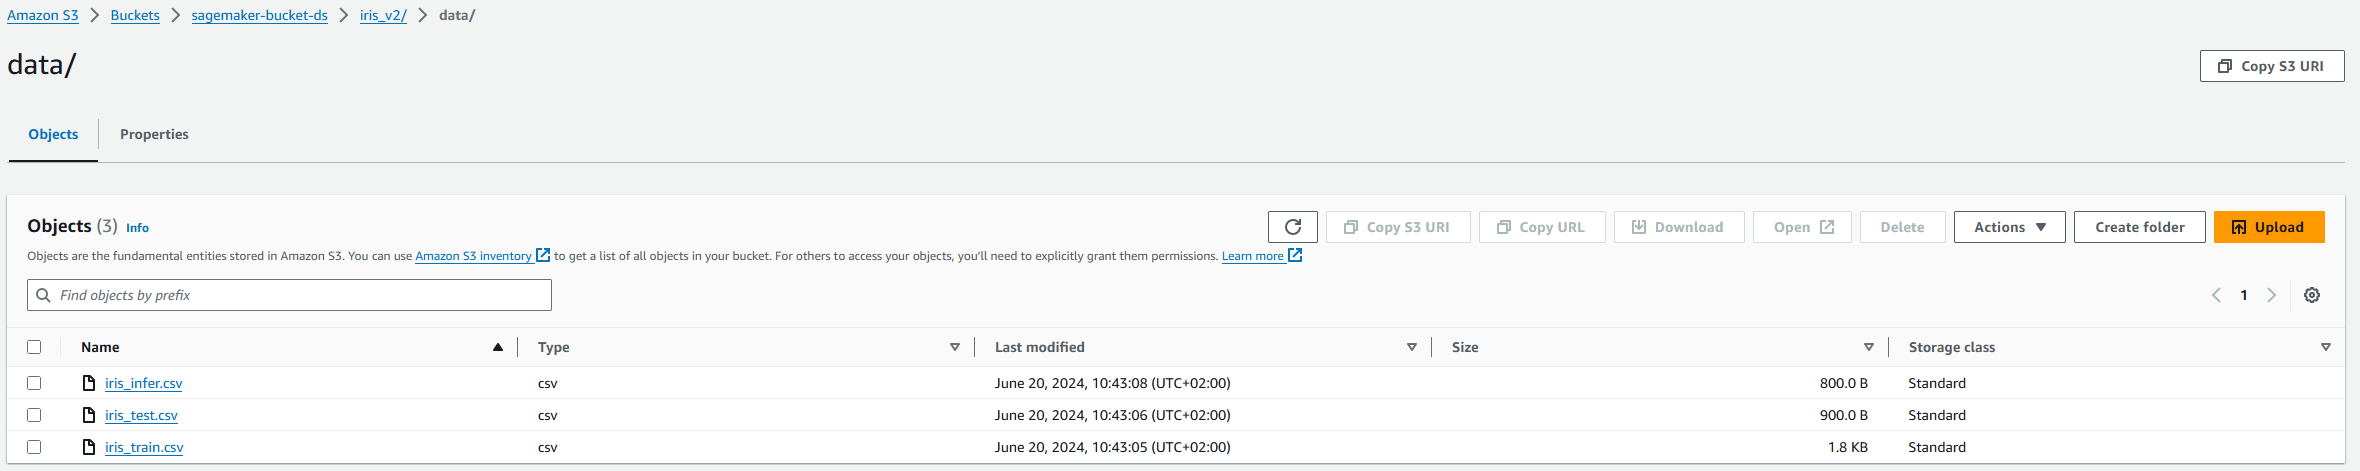